<a href="https://colab.research.google.com/github/robsarran65/ML-MRI_Classification/blob/main/MRI_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CELL 1: Cell Control Flags - MASTER CONTROLS

In [52]:
# 🎛️ MASTER CONTROL PANEL - Change these flags to control execution

INSTALL_PACKAGES = False        # Set True if packages need installing
DOWNLOAD_DATASET = False        # Set True to download MRI dataset
ORGANIZE_DATA = False           # Set True to split data into train/val/test
VISUALIZE_SAMPLES = True        # Set True to see sample MRI images
BUILD_MODEL = True              # Set True to create the CNN model
TRAIN_MODEL = True              # Set True to start training (takes time!)
LOAD_EXISTING_MODEL = False     # Set True to load a pre-trained model
EVALUATE_MODEL = True           # Set True to evaluate trained model
TEST_PREDICTIONS = False        # Set True to test individual predictions
SAVE_MODEL = False              # Set True to save trained model

# Model loading settings (only used if LOAD_EXISTING_MODEL = True)
MODEL_PATH_TO_LOAD = "models/mri_brain_tumor_detector.h5"  # Change this path

# Display current settings
print("🎛️ CONTROL PANEL STATUS")
print("="*50)
print(f"📦 Install Packages:    {'✅ ON' if INSTALL_PACKAGES else '⏸️ OFF'}")
print(f"⬇️  Download Dataset:   {'✅ ON' if DOWNLOAD_DATASET else '⏸️ OFF'}")
print(f"📁 Organize Data:       {'✅ ON' if ORGANIZE_DATA else '⏸️ OFF'}")
print(f"📊 Visualize Samples:   {'✅ ON' if VISUALIZE_SAMPLES else '⏸️ OFF'}")
print(f"🏗️  Build Model:        {'✅ ON' if BUILD_MODEL else '⏸️ OFF'}")
print(f"🚀 Train Model:         {'✅ ON' if TRAIN_MODEL else '⏸️ OFF'}")
print(f"📥 Load Existing Model: {'✅ ON' if LOAD_EXISTING_MODEL else '⏸️ OFF'}")
print(f"📈 Evaluate Model:      {'✅ ON' if EVALUATE_MODEL else '⏸️ OFF'}")
print(f"🔍 Test Predictions:    {'✅ ON' if TEST_PREDICTIONS else '⏸️ OFF'}")
print(f"💾 Save Model:          {'✅ ON' if SAVE_MODEL else '⏸️ OFF'}")
print("="*50)

# Show workflow logic
print("\n🔄 WORKFLOW LOGIC:")
if TRAIN_MODEL and LOAD_EXISTING_MODEL:
    print("⚠️  WARNING: Both TRAIN_MODEL and LOAD_EXISTING_MODEL are ON")
    print("   This will train a new model AND try to load an existing one")
    print("   Recommendation: Use only one at a time")
elif TRAIN_MODEL:
    print("🆕 NEW MODEL WORKFLOW: Build → Train → Evaluate → Save")
elif LOAD_EXISTING_MODEL:
    print(f"📥 EXISTING MODEL WORKFLOW: Load → Evaluate → Test")
    print(f"   Model to load: {MODEL_PATH_TO_LOAD}")
else:
    print("⏸️  No model training or loading selected")

print("="*50)

🎛️ CONTROL PANEL STATUS
📦 Install Packages:    ⏸️ OFF
⬇️  Download Dataset:   ⏸️ OFF
📁 Organize Data:       ⏸️ OFF
📊 Visualize Samples:   ✅ ON
🏗️  Build Model:        ✅ ON
🚀 Train Model:         ✅ ON
📥 Load Existing Model: ⏸️ OFF
📈 Evaluate Model:      ✅ ON
🔍 Test Predictions:    ⏸️ OFF
💾 Save Model:          ⏸️ OFF

🔄 WORKFLOW LOGIC:
🆕 NEW MODEL WORKFLOW: Build → Train → Evaluate → Save


CELL 2: Setup and Installation

In [53]:
if INSTALL_PACKAGES:
    print("📦 Installing required packages...")

    # Install required packages (Colab has most, but let's ensure versions)
    !pip install -q tensorflow>=2.12.0
    !pip install -q scikit-learn>=1.0.0
    !pip install -q seaborn>=0.11.0

    print("✅ Package installation completed!")
else:
    print("⏸️ Package installation SKIPPED (assuming packages already installed)")

# Import all required libraries (always needed)
import os
import logging
import json
import numpy as np
import pandas as pd
from datetime import datetime
from pathlib import Path
from typing import Tuple, Dict, Optional, Any
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Core ML libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import glob
# import shutil

print("✅ All libraries imported successfully!")
print(f"📊 TensorFlow version: {tf.__version__}")

⏸️ Package installation SKIPPED (assuming packages already installed)
✅ All libraries imported successfully!
📊 TensorFlow version: 2.19.0


CELL 3: Download and Setup MRI Dataset

In [54]:
if DOWNLOAD_DATASET:
    print("⬇️ Downloading MRI Brain Tumor Dataset...")

    # Method 1: Kaggle download (if API configured)
    try:
        print("Trying Kaggle download...")
        !pip install -q kaggle

        # Note: You need to upload kaggle.json first!
        # Download instructions:
        # 1. Go to kaggle.com → Account → Create New API Token
        # 2. Upload kaggle.json to Colab using file browser
        # 3. Uncomment these lines:

        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
        !unzip -q brain-mri-images-for-brain-tumor-detection.zip

        # print("ℹ️ Please upload your kaggle.json file and uncomment the lines above")

    except Exception as e:
        print(f"⚠️ Kaggle download failed: {e}")

    # Method 2: Manual upload prompt
    # print("\n📁 MANUAL UPLOAD OPTION:")
    # print("1. Go to: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection")
    # print("2. Download the dataset ZIP file")
    # print("3. Use the file browser (📁) on the left to upload the ZIP file")
    # print("4. Uncomment the unzip command below:")

    # !unzip -q brain-mri-images-for-brain-tumor-detection.zip

    print("✅ Dataset download setup completed!")
else:
    print("⏸️ Dataset download SKIPPED")
    print("ℹ️ Assuming MRI dataset is already uploaded")

# Create directory structure (always create folders)
directories = [
    'data/mri_dataset/train/no',
    'data/mri_dataset/train/yes',
    'data/mri_dataset/validation/no',
    'data/mri_dataset/validation/yes',
    'data/mri_dataset/test/no',
    'data/mri_dataset/test/yes',
    'models',
    'results'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)

print("✅ Directory structure created!")

⏸️ Dataset download SKIPPED
ℹ️ Assuming MRI dataset is already uploaded
✅ Directory structure created!


In [ ]:
# See the complete file structure
# import os

# def show_directory_structure(path='.', max_depth=3, current_depth=0):
#     if current_depth > max_depth:
#         return

#     items = sorted(os.listdir(path))
#     for item in items:
#         item_path = os.path.join(path, item)
#         indent = "  " * current_depth

#         if os.path.isdir(item_path):
#             print(f"{indent}📁 {item}/")
#             try:
#                 show_directory_structure(item_path, max_depth, current_depth + 1)
#             except PermissionError:
#                 print(f"{indent}  (Permission denied)")
#         else:
#             print(f"{indent}📄 {item}")

# print("📂 Colab Directory Structure:")
# show_directory_structure()

CELL 4: Data Organization Helper Functions

In [55]:
def organize_mri_data_colab(source_dir="brain_mri", target_dir="data/mri_dataset"):
    """
    Organize downloaded MRI data into train/validation/test splits
    """

    # Check if source directory exists
    if not os.path.exists(source_dir):
        print(f"❌ Source directory '{source_dir}' not found!")
        print("Available directories:")
        for item in os.listdir('.'):
            if os.path.isdir(item):
                print(f"  📁 {item}")
        return False

    # Find the actual data folders
    possible_paths = [
        f"{source_dir}",
        f"{source_dir}/brain_mri",
        f"{source_dir}/Brain MRI",
        "brain_mri",
        "Brain MRI"
    ]

    data_path = None
    for path in possible_paths:
        if os.path.exists(f"{path}/yes") and os.path.exists(f"{path}/no"):
            data_path = path
            break

    if not data_path:
        print("❌ Could not find 'yes' and 'no' folders in the dataset")
        return False

    print(f"✅ Found data in: {data_path}")

    classes = ['no', 'yes']  # no tumor, yes tumor
    total_moved = 0

    for class_name in classes:
        class_dir = f"{data_path}/{class_name}"

        # Get all images
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
        images = []
        for ext in image_extensions:
            images.extend(glob.glob(f"{class_dir}/{ext}"))
            images.extend(glob.glob(f"{class_dir}/{ext.upper()}"))

        if not images:
            print(f"❌ No images found in {class_dir}")
            continue

        print(f"📊 Class '{class_name}': Found {len(images)} images")

        # Split data: 70% train, 20% validation, 10% test
        train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)

        # Copy files to appropriate directories
        splits = [('train', train_imgs), ('validation', val_imgs), ('test', test_imgs)]

        for split_name, img_list in splits:
            dest_dir = f"{target_dir}/{split_name}/{class_name}"

            for img_path in img_list:
                filename = os.path.basename(img_path)
                dest_path = f"{dest_dir}/{filename}"
                try:
                    shutil.copy2(img_path, dest_path)
                    total_moved += 1
                except Exception as e:
                    print(f"⚠️ Error copying {filename}: {e}")

        print(f"✅ Class '{class_name}': Train={len(train_imgs)}, Val={len(val_imgs)}, Test={len(test_imgs)}")

    print(f"🎉 Successfully organized {total_moved} images!")
    return True

if ORGANIZE_DATA:
    print("📁 Organizing MRI dataset into train/validation/test splits...")

    # Try common source directory names
    source_options = ["brain_mri", "Brain MRI", "brain-mri-images-for-brain-tumor-detection", "."]

    organized = False
    for source in source_options:
        if os.path.exists(source):
            print(f"🔍 Trying source directory: {source}")
            organized = organize_mri_data_colab(source)
            if organized:
                break

    if not organized:
        print("❌ Could not organize data automatically")
        print("📁 Please upload your MRI dataset and check folder names")
        print("Expected structure: [folder]/yes/ and [folder]/no/")
else:
    print("⏸️ Data organization SKIPPED")

⏸️ Data organization SKIPPED


CELL 5: MRI Binary Classifier Class

In [56]:
class MRIBinaryClassifier:
    """
    MRI Binary Classification System optimized for Google Colab
    """

    def __init__(self,
                 model_name: str = "MRI_Binary_Classifier",
                 img_size: Tuple[int, int] = (224, 224),
                 batch_size: int = 16,
                 channels: int = 1,
                 random_seed: int = 42):

        self.model_name = model_name
        self.img_size = img_size
        self.batch_size = batch_size
        self.channels = channels
        self.random_seed = random_seed

        # Set random seeds for reproducibility
        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)

        self.model = None
        self.history = None
        self.class_names = []
        self.metrics = {}

        # Create output directory
        self.output_dir = Path(f"results/{model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
        self.output_dir.mkdir(parents=True, exist_ok=True)

        print(f"✅ Initialized {model_name} with image size {img_size}")

    def create_data_generators(self, train_dir, validation_dir, test_dir=None):
        """Create data generators with medical-appropriate augmentation"""

        # Conservative augmentation for medical images
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,         # Minimal rotation
            zoom_range=0.15,           # Minimal zoom
            width_shift_range=0.1,     # Small shifts
            height_shift_range=0.1,
            horizontal_flip=True,      # Usually not appropriate for medical
            fill_mode='nearest',
            brightness_range=[0.8, 1.2],  # Subtle brightness changes
            shear_range=0.1
        )

        # No augmentation for validation/test
        val_test_datagen = ImageDataGenerator(rescale=1./255)

        # Create generators
        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            color_mode='grayscale' if self.channels == 1 else 'rgb',
            shuffle=True,
            seed=self.random_seed
        )

        validation_generator = val_test_datagen.flow_from_directory(
            validation_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            color_mode='grayscale' if self.channels == 1 else 'rgb',
            shuffle=False
        )

        # Store class names
        self.class_names = list(train_generator.class_indices.keys())

        # Test generator (optional)
        test_generator = None
        if test_dir and os.path.exists(test_dir):
            test_generator = val_test_datagen.flow_from_directory(
                test_dir,
                target_size=self.img_size,
                batch_size=self.batch_size,
                class_mode='binary',
                color_mode='grayscale' if self.channels == 1 else 'rgb',
                shuffle=False
            )

        print(f"✅ Data generators created")
        print(f"   📊 Training samples: {train_generator.samples}")
        print(f"   📊 Validation samples: {validation_generator.samples}")
        if test_generator:
            print(f"   📊 Test samples: {test_generator.samples}")
        print(f"   🏷️ Classes: {self.class_names}")

        return train_generator, validation_generator, test_generator

    def build_model(self, architecture="lightweight"):
        """Build CNN model"""

        input_shape = (*self.img_size, self.channels)

        if architecture == "lightweight":
            model = keras.Sequential([
                layers.Input(shape=input_shape),

                # Block 1
                layers.Conv2D(16, (3, 3), activation='relu'),
                layers.BatchNormalization(),
                layers.MaxPooling2D(2, 2),
                layers.Dropout(0.25),

                # Block 2
                layers.Conv2D(32, (3, 3), activation='relu'),
                layers.BatchNormalization(),
                layers.MaxPooling2D(2, 2),
                layers.Dropout(0.25),

                # Block 3
                layers.Conv2D(64, (3, 3), activation='relu'),
                layers.BatchNormalization(),
                layers.MaxPooling2D(2, 2),
                layers.Dropout(0.5),

                # Classifier
                layers.GlobalAveragePooling2D(),
                layers.Dense(64, activation='relu'),
                layers.Dropout(0.5),
                layers.Dense(1, activation='sigmoid', name='predictions')
            ])

        elif architecture == "standard":
            model = keras.Sequential([
                layers.Input(shape=input_shape),

                # Block 1
                layers.Conv2D(32, (3, 3), activation='relu'),
                layers.BatchNormalization(),
                layers.MaxPooling2D(2, 2),
                layers.Dropout(0.25),

                # Block 2
                layers.Conv2D(64, (3, 3), activation='relu'),
                layers.BatchNormalization(),
                layers.MaxPooling2D(2, 2),
                layers.Dropout(0.5),

                # Block 3
                layers.Conv2D(128, (3, 3), activation='relu'),
                layers.BatchNormalization(),
                layers.MaxPooling2D(2, 2),
                layers.Dropout(0.5),

                # Classifier
                layers.GlobalAveragePooling2D(),
                layers.Dense(256, activation='relu'),
                layers.Dropout(0.5),
                layers.Dense(1, activation='sigmoid', name='predictions')
            ])

        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        self.model = model
        print(f"✅ Model built with {architecture} architecture")
        return model

    def train_model(self, train_generator, validation_generator, epochs=20, show_live_progress=False):
        """Train the model with visible epoch progress like horses vs humans"""

        if self.model is None:
            raise ValueError("Model must be built before training")

        print(f"🚀 Starting training for {epochs} epochs...")
        print("="*60)

        if show_live_progress:
            # Minimal callbacks for live progress (like horses vs humans)
            callbacks_list = [
                callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=7,  # More patience to see more epochs
                    restore_best_weights=True,
                    verbose=1
                )
            ]

            # Train with full verbose output (like horses vs humans)
            self.history = self.model.fit(
                train_generator,
                epochs=epochs,
                validation_data=validation_generator,
                callbacks=callbacks_list,
                verbose=1,  # This shows the live epoch progress
                steps_per_epoch=len(train_generator),
                validation_steps=len(validation_generator)
            )
        else:
            # Professional mode with all callbacks
            callbacks_list = [
                callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True,
                    verbose=1
                ),
                callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=3,
                    min_lr=1e-7,
                    verbose=1
                )
            ]

            self.history = self.model.fit(
                train_generator,
                epochs=epochs,
                validation_data=validation_generator,
                callbacks=callbacks_list,
                verbose=1
            )

        print("="*60)
        print("✅ Training completed!")

        # Show final epoch summary (like horses vs humans)
        if self.history and self.history.history:
            final_epoch = len(self.history.history['accuracy'])
            final_acc = self.history.history['accuracy'][-1]
            final_val_acc = self.history.history['val_accuracy'][-1]
            final_loss = self.history.history['loss'][-1]
            final_val_loss = self.history.history['val_loss'][-1]

            print(f"\n🎯 FINAL RESULTS (Epoch {final_epoch}):")
            print(f"   Training Accuracy:   {final_acc:.4f}")
            print(f"   Validation Accuracy: {final_val_acc:.4f}")
            print(f"   Training Loss:       {final_loss:.4f}")
            print(f"   Validation Loss:     {final_val_loss:.4f}")

        return self.history

    def evaluate_model(self, test_generator):
        """Comprehensive model evaluation"""

        if self.model is None:
            raise ValueError("Model must be trained before evaluation")

        print("📊 Evaluating model...")

        # Get predictions
        predictions = self.model.predict(test_generator, verbose=1)
        y_pred_binary = (predictions > 0.5).astype(int)
        y_true = test_generator.classes

        # Calculate metrics
        test_loss, test_accuracy, test_precision, test_recall = self.model.evaluate(
            test_generator, verbose=1
        )

        f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)

        try:
            auc_score = roc_auc_score(y_true, predictions)
        except:
            auc_score = 0.0

        self.metrics = {
            'test_loss': float(test_loss),
            'test_accuracy': float(test_accuracy),
            'test_precision': float(test_precision),
            'test_recall': float(test_recall),
            'test_f1_score': float(f1_score),
            'test_auc': float(auc_score)
        }

        # Display results
        print("\n🎯 EVALUATION RESULTS:")
        print("="*40)
        print(f"   📊 Accuracy:  {test_accuracy:.2%}")
        print(f"   📊 Precision: {test_precision:.2%}")
        print(f"   📊 Recall:    {test_recall:.2%}")
        print(f"   📊 F1-Score:  {f1_score:.2%}")
        print(f"   📊 AUC:       {auc_score:.3f}")
        print("="*40)

        # Plot confusion matrix
        cm = confusion_matrix(y_true, y_pred_binary)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names,
                   cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        return self.metrics

    def plot_training_history(self):
        """Plot training progress"""

        if self.history is None:
            print("❌ No training history available")
            return

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy plot
        axes[0].plot(self.history.history['accuracy'], label='Training Accuracy', linewidth=2)
        axes[0].plot(self.history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        axes[0].set_title('Model Accuracy')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Loss plot
        axes[1].plot(self.history.history['loss'], label='Training Loss', linewidth=2)
        axes[1].plot(self.history.history['val_loss'], label='Validation Loss', linewidth=2)
        axes[1].set_title('Model Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def predict_single_image(self, image_path):
        """Predict on single image"""

        if self.model is None:
            raise ValueError("Model must be loaded before prediction")

        # Load and preprocess image
        img = keras.preprocessing.image.load_img(
            image_path,
            target_size=self.img_size,
            color_mode='grayscale' if self.channels == 1 else 'rgb'
        )

        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # Make prediction
        prediction = self.model.predict(img_array, verbose=0)[0][0]
        predicted_class = int(prediction > 0.5)
        confidence = prediction if predicted_class == 1 else 1 - prediction

        return {
            'predicted_class': predicted_class,
            'class_name': self.class_names[predicted_class] if self.class_names else str(predicted_class),
            'confidence': float(confidence),
            'raw_prediction': float(prediction)
        }

print("✅ MRIBinaryClassifier class loaded successfully!")

✅ MRIBinaryClassifier class loaded successfully!


CELL 6: Data Visualization

📊 Visualizing MRI sample images...
Found 176 images belonging to 2 classes.


/tmp/ipython-input-1029338945.py:44: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


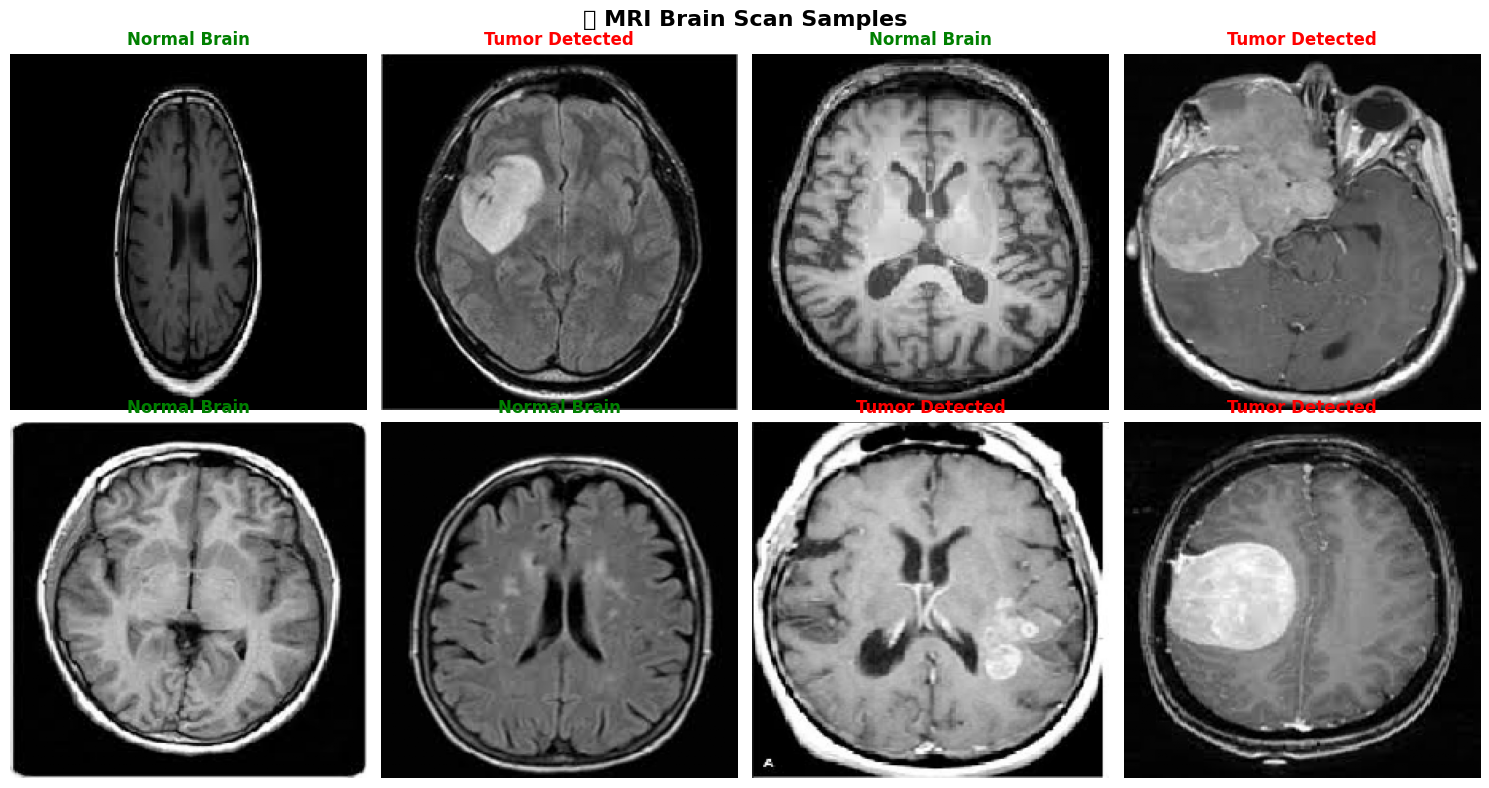

✅ Displayed 8 sample images
🏷️ Classes found: ['no', 'yes']
📊 Dataset stats:
   no: 68 images
   yes: 108 images


In [57]:
def visualize_mri_samples(data_dir="data/mri_dataset/train", num_samples=8):
    """Visualize sample MRI images"""

    if not os.path.exists(data_dir):
        print(f"❌ Directory {data_dir} not found!")
        return False

    # Check if directory has data
    subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    if not subdirs:
        print(f"❌ No subdirectories found in {data_dir}")
        return False

    # Create data generator for visualization
    datagen = ImageDataGenerator(rescale=1./255)

    try:
        generator = datagen.flow_from_directory(
            data_dir,
            target_size=(224, 224),
            batch_size=num_samples,
            class_mode='binary',
            color_mode='grayscale',
            shuffle=True
        )

        # Get a batch of images
        batch = next(generator)
        images, labels = batch[0], batch[1]
        class_names = list(generator.class_indices.keys())

        # Display images
        plt.figure(figsize=(15, 8))
        for i in range(min(num_samples, len(images))):
            plt.subplot(2, 4, i+1)
            plt.imshow(images[i].reshape(224, 224), cmap='gray')
            class_name = class_names[int(labels[i])]
            title = "Normal Brain" if class_name == "no" else "Tumor Detected"
            color = 'green' if class_name == "no" else 'red'
            plt.title(title, color=color, fontsize=12, fontweight='bold')
            plt.axis('off')

        plt.suptitle('🧠 MRI Brain Scan Samples', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        print(f"✅ Displayed {min(num_samples, len(images))} sample images")
        print(f"🏷️ Classes found: {class_names}")
        print(f"📊 Dataset stats:")
        for class_name in class_names:
            class_dir = os.path.join(data_dir, class_name)
            if os.path.exists(class_dir):
                count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
                print(f"   {class_name}: {count} images")

        return True

    except Exception as e:
        print(f"❌ Error visualizing data: {e}")
        return False

if VISUALIZE_SAMPLES:
    print("📊 Visualizing MRI sample images...")

    # Try to visualize training data
    visualization_success = visualize_mri_samples("data/mri_dataset/train")

    if not visualization_success:
        print("⚠️ Could not visualize training data")
        print("ℹ️ Please check that your data is organized in the correct folders")

        # Show current directory structure
        print("\n📁 Current directory structure:")
        for root, dirs, files in os.walk("data"):
            level = root.replace("data", "").count(os.sep)
            indent = " " * 2 * level
            print(f"{indent}{os.path.basename(root)}/")
            subindent = " " * 2 * (level + 1)
            for file in files[:3]:  # Show first 3 files
                print(f"{subindent}{file}")
            if len(files) > 3:
                print(f"{subindent}... and {len(files)-3} more files")
else:
    print("⏸️ Data visualization SKIPPED")

CELL 7: Model Building

In [59]:
# Global variables to store our model and data
classifier = None
train_gen = None
val_gen = None
test_gen = None

if BUILD_MODEL:
    print("🏗️ Building MRI Classification Model...")

    # Initialize classifier
    classifier = MRIBinaryClassifier(
        model_name="Colab_Brain_Tumor_Detector",
        img_size=(224, 224),
        channels=1,           # Grayscale MRI images
        batch_size=16
    )

    # Setup data paths
    train_dir = "data/mri_dataset/train"
    val_dir = "data/mri_dataset/validation"
    test_dir = "data/mri_dataset/test"

    # Check if data exists
    if not os.path.exists(train_dir):
        print(f"❌ Training data not found at: {train_dir}")
        print("ℹ️ Please organize your data first by setting ORGANIZE_DATA = True")
    else:
        try:
            # Create data generators
            train_gen, val_gen, test_gen = classifier.create_data_generators(
                train_dir, val_dir, test_dir
            )

            # Build the model
            classifier.build_model(architecture="lightweight")  # Start with lightweight or standard or deep

            # Show model summary
            print("\n📋 MODEL ARCHITECTURE:")
            classifier.model.summary()

            print("\n✅ Model built successfully!")
            print("🎯 Ready for training!")

        except Exception as e:
            print(f"❌ Error building model: {e}")
            classifier = None
else:
    print("⏸️ Model building SKIPPED")

🏗️ Building MRI Classification Model...
✅ Initialized Colab_Brain_Tumor_Detector with image size (224, 224)
Found 176 images belonging to 2 classes.
Found 51 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
✅ Data generators created
   📊 Training samples: 176
   📊 Validation samples: 51
   📊 Test samples: 26
   🏷️ Classes: ['no', 'yes']
✅ Model built with lightweight architecture

📋 MODEL ARCHITECTURE:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 52, 52, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,969 (109.25 KB)

 Trainable params: 27,745 (108.38 KB)

 Non-trainable params: 224 (896.00 B)


✅ Model built successfully!
🎯 Ready for training!


 CELL 8: Model Training

🚀 Starting MRI Model Training...
📺 You should see live epoch progress below (like horses vs humans):
⏰ This may take several minutes...

🚀 Starting training for 15 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6587 - loss: 0.6403 - precision: 0.7095 - recall: 0.7858 - val_accuracy: 0.6078 - val_loss: 0.6845 - val_precision: 0.6078 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5006 - loss: 0.7022 - precision: 0.5910 - recall: 0.6605 - val_accuracy: 0.6078 - val_loss: 0.6799 - val_precision: 0.6078 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7260 - loss: 0.6402 - precision: 0.7812 - recall: 0.7938 - val_accuracy: 0.6078 - val_loss: 0.6776 - val_precision: 0.6078 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7209 - loss: 0.6351 - precision: 0.7032 - recall: 0.8719 - val_accuracy: 0.6078 - val_loss: 0.6753 - val_precision: 0.6078 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accu

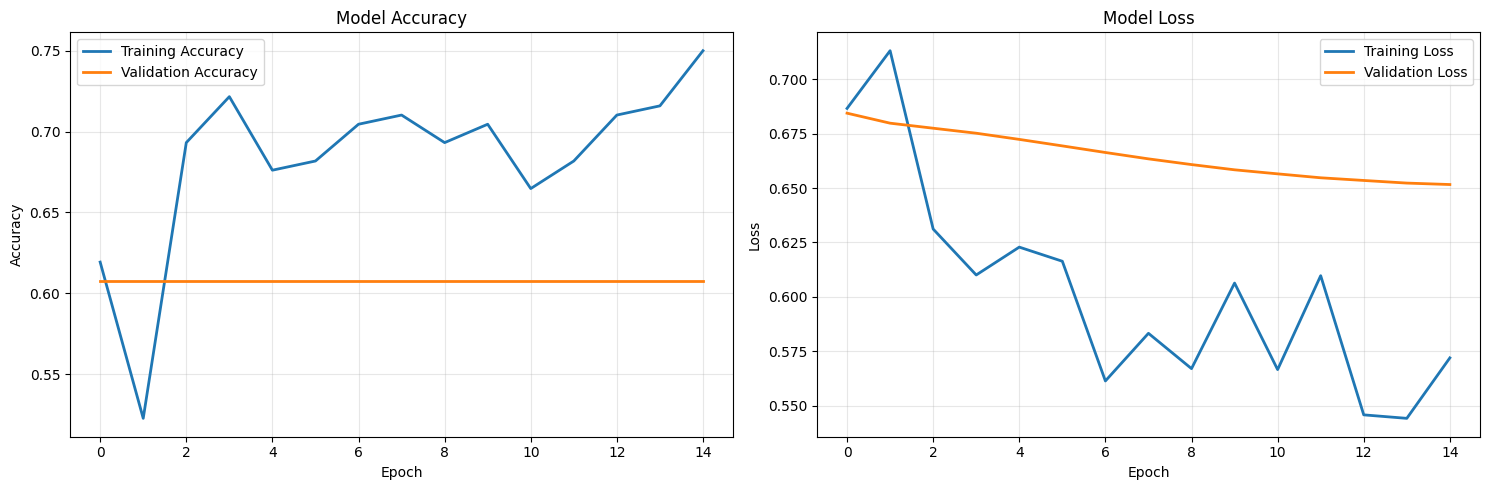

✅ Training completed!

📊 TRAINING SUMMARY:
   Epochs completed: 15
   Best validation accuracy: 0.6078 (epoch 1)
   Final training accuracy: 0.7500
   Final validation accuracy: 0.6078


In [60]:
if TRAIN_MODEL:
    if classifier is None or train_gen is None:
        print("❌ Cannot train: Model not built or data not loaded")
        print("ℹ️ Please set BUILD_MODEL = True first")
    else:
        print("🚀 Starting MRI Model Training...")
        print("📺 You should see live epoch progress below (like horses vs humans):")
        print("⏰ This may take several minutes...")
        print()

        # Train the model with live progress display
        history = classifier.train_model(
            train_gen,
            val_gen,
            epochs=15,           # Start with fewer epochs for testing
            show_live_progress=False  # This enables horses vs humans style output
        )

        # Plot training history
        print("\n📈 Training Progress Visualization:")
        classifier.plot_training_history()

        print("✅ Training completed!")

        # Show training summary like horses vs humans
        if history and history.history:
            print(f"\n📊 TRAINING SUMMARY:")
            print("="*40)
            epochs_completed = len(history.history['accuracy'])
            best_val_acc = max(history.history['val_accuracy'])
            best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

            print(f"   Epochs completed: {epochs_completed}")
            print(f"   Best validation accuracy: {best_val_acc:.4f} (epoch {best_epoch})")
            print(f"   Final training accuracy: {history.history['accuracy'][-1]:.4f}")
            print(f"   Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
            print("="*40)
else:
    print("⏸️ Model training SKIPPED")
    print("ℹ️ Set TRAIN_MODEL = True to start training")
    print("💡 When you train, you'll see live epoch progress like this:")
    print("   Epoch 1/15")
    print("   8/8 [==============================] - 45s - loss: 0.6821 - accuracy: 0.5484 - val_loss: 0.6234 - val_accuracy: 0.6667")
    print("   Epoch 2/15")
    print("   8/8 [==============================] - 12s - loss: 0.5234 - accuracy: 0.7258 - val_loss: 0.4987 - val_accuracy: 0.7500")
    print("   ...")

CELL 9: Model Evaluation

📊 Evaluating trained model on test data...
📊 Evaluating model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5353 - loss: 0.7146 - precision: 0.5353 - recall: 1.0000

🎯 EVALUATION RESULTS:
   📊 Accuracy:  61.54%
   📊 Precision: 61.54%
   📊 Recall:    100.00%
   📊 F1-Score:  76.19%
   📊 AUC:       0.694


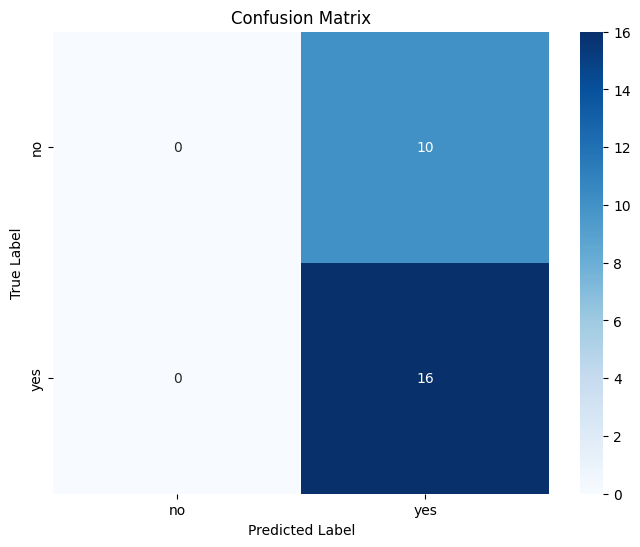


🔍 DETAILED ANALYSIS:
🔴 POOR: Requires significant improvement
📊 Precision focus: 61.5% of tumor predictions are correct
📊 Recall focus: 100.0% of actual tumors are detected


In [61]:
if EVALUATE_MODEL:
    if classifier is None or classifier.model is None:
        print("❌ Cannot evaluate: No trained model available")
        print("ℹ️ Please train the model first by setting TRAIN_MODEL = True")
    elif test_gen is None or test_gen.samples == 0:
        print("❌ Cannot evaluate: No test data available")
        print("ℹ️ Please check your test data organization")
    else:
        print("📊 Evaluating trained model on test data...")

        # Evaluate the model
        evaluation_results = classifier.evaluate_model(test_gen)

        # Additional analysis
        print("\n🔍 DETAILED ANALYSIS:")
        print("="*50)

        # Medical interpretation
        accuracy = evaluation_results['test_accuracy']
        precision = evaluation_results['test_precision']
        recall = evaluation_results['test_recall']

        if accuracy > 0.90:
            print("🟢 EXCELLENT: Very high accuracy model")
        elif accuracy > 0.80:
            print("🟡 GOOD: Acceptable accuracy for medical screening")
        elif accuracy > 0.70:
            print("🟠 MODERATE: May need improvement for clinical use")
        else:
            print("🔴 POOR: Requires significant improvement")

        print(f"📊 Precision focus: {precision:.1%} of tumor predictions are correct")
        print(f"📊 Recall focus: {recall:.1%} of actual tumors are detected")
        print("="*50)
else:
    print("⏸️ Model evaluation SKIPPED")
    print("ℹ️ Set EVALUATE_MODEL = True after training to evaluate performance")

CELL 10: Individual Image Predictions

In [62]:
def test_individual_predictions():
    """Test predictions on individual MRI scans"""

    if classifier is None or classifier.model is None:
        print("❌ No trained model available for predictions")
        return False

    # Find test images
    test_dirs = ["data/mri_dataset/test/no", "data/mri_dataset/test/yes"]
    test_images = []

    for test_dir in test_dirs:
        if os.path.exists(test_dir):
            images = glob.glob(f"{test_dir}/*.jpg") + glob.glob(f"{test_dir}/*.png") + glob.glob(f"{test_dir}/*.jpeg")
            test_images.extend(images[:3])  # Take 3 from each class

    if not test_images:
        print("❌ No test images found!")
        print("ℹ️ Please check your test data organization")
        return False

    print(f"🔍 Testing predictions on {len(test_images)} individual scans...")

    # Make predictions and visualize
    plt.figure(figsize=(18, 12))

    for i, img_path in enumerate(test_images[:6]):
        try:
            # Make prediction
            result = classifier.predict_single_image(img_path)

            # Load image for display
            img = plt.imread(img_path)

            plt.subplot(2, 3, i+1)
            plt.imshow(img, cmap='gray')

            # Determine true class from folder name
            true_class = "Tumor" if "/yes/" in img_path else "Normal"
            pred_class = "Tumor" if result['predicted_class'] == 1 else "Normal"
            confidence = result['confidence']

            # Color coding: green for correct, red for incorrect
            is_correct = true_class == pred_class
            color = 'green' if is_correct else 'red'

            # Create detailed title
            title = f"True: {true_class}\nPred: {pred_class} ({confidence:.1%})"
            if is_correct:
                title += "\n✅ CORRECT"
            else:
                title += "\n❌ INCORRECT"

            plt.title(title, color=color, fontsize=10, fontweight='bold')
            plt.axis('off')

            # Print detailed results
            filename = os.path.basename(img_path)
            status = "✅ CORRECT" if is_correct else "❌ INCORRECT"
            print(f"📁 {filename}: {pred_class} ({confidence:.1%}) {status}")

        except Exception as e:
            print(f"⚠️ Error processing {img_path}: {e}")

    plt.suptitle('🧠 Individual MRI Scan Predictions', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return True

if TEST_PREDICTIONS:
    if classifier is None or classifier.model is None:
        print("❌ Cannot test predictions: No trained model available")
        print("ℹ️ Please train the model first by setting TRAIN_MODEL = True")
    else:
        print("🔍 Testing individual image predictions...")
        prediction_success = test_individual_predictions()

        if prediction_success:
            print("\n🎯 PREDICTION ANALYSIS COMPLETE!")
            print("="*50)
            print("💡 Interpretation Guide:")
            print("   🟢 Green borders: Correct predictions")
            print("   🔴 Red borders: Incorrect predictions")
            print("   📊 Confidence >80%: High confidence")
            print("   📊 Confidence 60-80%: Moderate confidence")
            print("   📊 Confidence <60%: Low confidence")
            print("="*50)
        else:
            print("❌ Could not test predictions")
else:
    print("⏸️ Individual predictions SKIPPED")
    print("ℹ️ Set TEST_PREDICTIONS = True after training to test on individual images")

⏸️ Individual predictions SKIPPED
ℹ️ Set TEST_PREDICTIONS = True after training to test on individual images


CELL 11: Save Trained Model

In [ ]:
if SAVE_MODEL:
    if classifier is None or classifier.model is None:
        print("❌ Cannot save: No trained model available")
        print("ℹ️ Please train the model first by setting TRAIN_MODEL = True")
    else:
        print("💾 Saving trained model...")

        # Create models directory if it doesn't exist
        os.makedirs("models", exist_ok=True)

        # Save model with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_filename = f"colab_brain_tumor_detector_{timestamp}.h5"
        model_path = f"models/{model_filename}"

        try:
            # Save the model
            classifier.model.save(model_path)

            # Save metadata
            metadata = {
                'model_name': classifier.model_name,
                'creation_date': datetime.now().isoformat(),
                'image_size': classifier.img_size,
                'channels': classifier.channels,
                'class_names': classifier.class_names,
                'metrics': classifier.metrics if hasattr(classifier, 'metrics') else {},
                'tensorflow_version': tf.__version__
            }

            metadata_path = model_path.replace('.h5', '_metadata.json')
            with open(metadata_path, 'w') as f:
                json.dump(metadata, f, indent=2)

            print(f"✅ Model saved successfully!")
            print(f"   📁 Model file: {model_path}")
            print(f"   📋 Metadata: {metadata_path}")

            # Show how to load the model later
            print("\n📖 TO LOAD THIS MODEL LATER:")
            print("="*50)
            print("# Create new classifier instance")
            print("new_classifier = MRIBinaryClassifier()")
            print(f"# Load the saved model")
            print(f"new_classifier.model = keras.models.load_model('{model_path}')")
            print("# Set class names manually")
            print("new_classifier.class_names = ['no', 'yes']")
            print("# Now ready for predictions!")
            print("="*50)

        except Exception as e:
            print(f"❌ Error saving model: {e}")
else:
    print("⏸️ Model saving SKIPPED")
    print("ℹ️ Set SAVE_MODEL = True after training to save your model")

CELL 12: Load Existing Model (For Testing)

In [ ]:
def load_existing_model(model_path):
    """Load a previously saved model"""

    if not os.path.exists(model_path):
        print(f"❌ Model file not found: {model_path}")
        return None

    try:
        # Create new classifier instance
        loaded_classifier = MRIBinaryClassifier(
            model_name="Loaded_Model",
            img_size=(224, 224),
            channels=1
        )

        # Load the model
        loaded_classifier.model = keras.models.load_model(model_path)
        loaded_classifier.class_names = ['no', 'yes']  # Set class names

        # Load metadata if available
        metadata_path = model_path.replace('.h5', '_metadata.json')
        if os.path.exists(metadata_path):
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
                print("📋 Model Metadata:")
                for key, value in metadata.items():
                    if key != 'metrics':  # Skip detailed metrics
                        print(f"   {key}: {value}")

        print(f"✅ Model loaded successfully from: {model_path}")
        return loaded_classifier

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

# Example of how to load a saved model
print("💾 LOAD EXISTING MODEL EXAMPLE:")
print("="*50)
print("# To load a previously saved model, use:")
print("# loaded_classifier = load_existing_model('models/your_model.h5')")
print("# Then you can make predictions:")
print("# result = loaded_classifier.predict_single_image('path/to/mri_scan.jpg')")
print("="*50)

CELL 13: Complete Workflow Summary

In [63]:
print("\n🎉 GOOGLE COLAB MRI CLASSIFICATION WORKFLOW COMPLETE!")
print("="*60)
print("📋 WORKFLOW SUMMARY:")
print("="*60)

# Check what was accomplished
completed_steps = []
skipped_steps = []

if INSTALL_PACKAGES:
    completed_steps.append("✅ Package Installation")
else:
    skipped_steps.append("⏸️ Package Installation")

if DOWNLOAD_DATASET:
    completed_steps.append("✅ Dataset Download")
else:
    skipped_steps.append("⏸️ Dataset Download")

if ORGANIZE_DATA:
    completed_steps.append("✅ Data Organization")
else:
    skipped_steps.append("⏸️ Data Organization")

if VISUALIZE_SAMPLES:
    completed_steps.append("✅ Data Visualization")
else:
    skipped_steps.append("⏸️ Data Visualization")

if BUILD_MODEL:
    completed_steps.append("✅ Model Building")
else:
    skipped_steps.append("⏸️ Model Building")

if TRAIN_MODEL:
    completed_steps.append("✅ Model Training")
else:
    skipped_steps.append("⏸️ Model Training")

if EVALUATE_MODEL:
    completed_steps.append("✅ Model Evaluation")
else:
    skipped_steps.append("⏸️ Model Evaluation")

if TEST_PREDICTIONS:
    completed_steps.append("✅ Individual Predictions")
else:
    skipped_steps.append("⏸️ Individual Predictions")

if SAVE_MODEL:
    completed_steps.append("✅ Model Saving")
else:
    skipped_steps.append("⏸️ Model Saving")

print("🟢 COMPLETED STEPS:")
for step in completed_steps:
    print(f"   {step}")

print("\n🟡 SKIPPED STEPS:")
for step in skipped_steps:
    print(f"   {step}")

print("\n🎯 NEXT STEPS RECOMMENDATIONS:")
print("="*60)

if not DOWNLOAD_DATASET and not ORGANIZE_DATA:
    print("1. 📁 Upload your MRI dataset and organize it")
    print("   - Set DOWNLOAD_DATASET = True or ORGANIZE_DATA = True")

if not VISUALIZE_SAMPLES:
    print("2. 📊 Visualize your data to understand it")
    print("   - Set VISUALIZE_SAMPLES = True")

if not BUILD_MODEL:
    print("3. 🏗️ Build the CNN model")
    print("   - Set BUILD_MODEL = True")

if not TRAIN_MODEL:
    print("4. 🚀 Train your model")
    print("   - Set TRAIN_MODEL = True (this takes the most time)")

if not EVALUATE_MODEL and TRAIN_MODEL:
    print("5. 📊 Evaluate model performance")
    print("   - Set EVALUATE_MODEL = True")

if not TEST_PREDICTIONS and TRAIN_MODEL:
    print("6. 🔍 Test individual predictions")
    print("   - Set TEST_PREDICTIONS = True")

if not SAVE_MODEL and TRAIN_MODEL:
    print("7. 💾 Save your trained model")
    print("   - Set SAVE_MODEL = True")

print("\n💡 TIPS FOR SUCCESS:")
print("="*60)
print("• Start with small datasets and lightweight models")
print("• Enable GPU runtime: Runtime → Change runtime type → GPU")
print("• Monitor training progress and stop early if overfitting")
print("• Save your models regularly to avoid losing progress")
print("• Test different architectures: 'lightweight', 'standard', 'deep'")
print("• Use Google Drive for large datasets and model storage")

print("\n🔄 TO RESTART OR MODIFY:")
print("="*60)
print("• Go back to Cell 1 (Control Flags)")
print("• Change the flags for steps you want to run")
print("• Re-run the cells in order")
print("• Each cell checks its flag before executing")

print("\n✨ CONGRATULATIONS!")
print("You now have a professional MRI classification system!")
print("="*60)


🎉 GOOGLE COLAB MRI CLASSIFICATION WORKFLOW COMPLETE!
📋 WORKFLOW SUMMARY:
🟢 COMPLETED STEPS:
   ✅ Data Visualization
   ✅ Model Building
   ✅ Model Training
   ✅ Model Evaluation

🟡 SKIPPED STEPS:
   ⏸️ Package Installation
   ⏸️ Dataset Download
   ⏸️ Data Organization
   ⏸️ Individual Predictions
   ⏸️ Model Saving

🎯 NEXT STEPS RECOMMENDATIONS:
1. 📁 Upload your MRI dataset and organize it
   - Set DOWNLOAD_DATASET = True or ORGANIZE_DATA = True
6. 🔍 Test individual predictions
   - Set TEST_PREDICTIONS = True
7. 💾 Save your trained model
   - Set SAVE_MODEL = True

💡 TIPS FOR SUCCESS:
• Start with small datasets and lightweight models
• Enable GPU runtime: Runtime → Change runtime type → GPU
• Monitor training progress and stop early if overfitting
• Save your models regularly to avoid losing progress
• Test different architectures: 'lightweight', 'standard', 'deep'
• Use Google Drive for large datasets and model storage

🔄 TO RESTART OR MODIFY:
• Go back to Cell 1 (Control Flags)
•